## Image Classification 

In this notebook, we're going to explore the use of a few different ways of setting up an image classification model. The images labels are available: http://cs231n.stanford.edu/tiny-imagenet-200.zip. The training set contains 500 images for each of 200 different classes. The validation set contains 50 images for each of the 200 classes. **You must download and unzip this file, putting the resulting directory in the same directory as your notebook.**

Each of the images is a 64x64 pixel image (4096) pixels, each with a rgb value, resulting in 12288 values describing each image.

First, we're going to load images from the tiny-imagenet-200 folder into a *flattened* format that is suitable for training any of the scikit-learn classifier models, such as a tree or logistic regression.

Later, we'll take advantage of data loading functions included in PyTorch that will preserve the 2D-shape of images and load *batches* instead of the entire training or validation set all at once.

**The code provided will show you how to load in the image data, train neural networks, and evaluate them.**

### Packages

You will need to install the `pytorch` and `torchvision` packages.
To do so, I suggest starting a terminal by choosing File -> New -> Terminal from the JupyterLab menu, and running
`conda install torchvision -c pytorch`

## Helper and Data Loading Functions

In [1]:
%matplotlib inline
%run Helpers.py

In [10]:
def load_train_dataset():
    data_path = 'tiny-imagenet-200/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader, train_dataset.class_to_idx

In [11]:
def load_valid_dataset(class_to_idx):
    data_path = 'tiny-imagenet-200/val/images'
    label_file = open('tiny-imagenet-200/val/val_annotations.txt', 'r')
    label_df = pd.read_csv(label_file, delim_whitespace=True, header=None)
    label_df[1] = label_df[1].apply(lambda x : class_to_idx[x])
    valid_data = []
    for row in label_df.iterrows():
        image = Image.open(f'{data_path}/{row[1][0]}')
        image = torchvision.transforms.functional.to_tensor(image)
        label = row[1][1]
        valid_data.append((image, label))
    return valid_data

In [12]:
def load_data_np(batches=100):
    # Load a subsample of training data and all of the validation data into a flattened NumPy format.
    train_data_np = []
    train_labels = []
    batch_limit = batches
    for index, (data, label) in enumerate(train_dataset):
        for i in range(data.shape[0]):
            train_data_np.append(data[i].detach().numpy().flatten())
            train_labels.append(int(label[i].detach().numpy()))
        if index >= batch_limit - 1:
            break
    train_data_np = np.vstack(train_data_np)
    train_labels = np.array(train_labels)

    valid_data_np = []
    valid_labels = []
    for data, label in valid_dataset:
        if data.shape[0] < 3:
            data = torch.cat([data[0], data[0], data[0]], dim=0)  # Convert grayscale images into RGB format
        valid_data_np.append(data.detach().numpy().flatten())
        valid_labels.append(int(label))
    valid_data_np = np.vstack(valid_data_np)
    valid_labels = np.array(valid_labels)
    return train_data_np, train_labels, valid_data_np, valid_labels

In [13]:
train_dataset, class_to_idx = load_train_dataset()
valid_dataset = load_valid_dataset(class_to_idx)

## Visualize Images and Labels

C:\Users\soode\AppData\Local\Temp\ipykernel_35928\3477741890.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


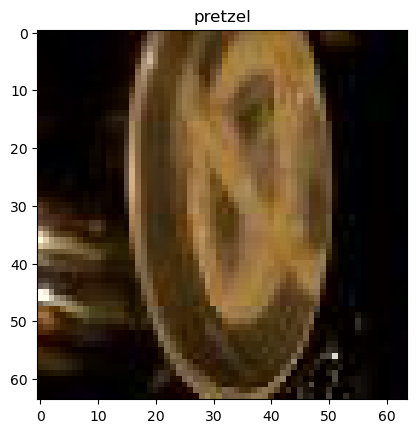

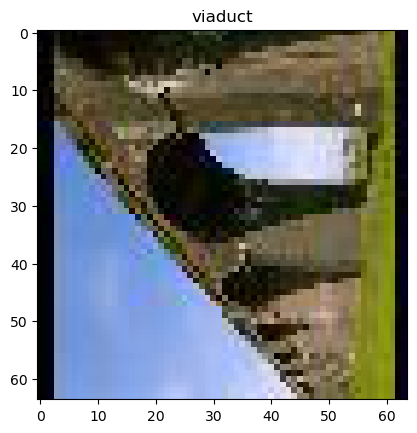

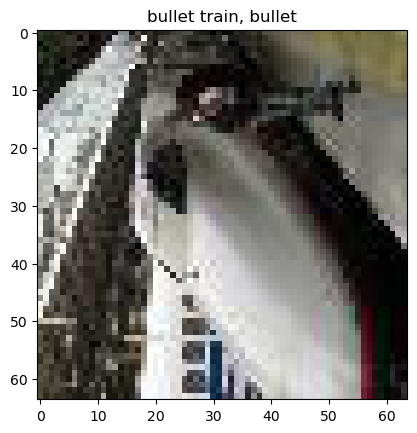

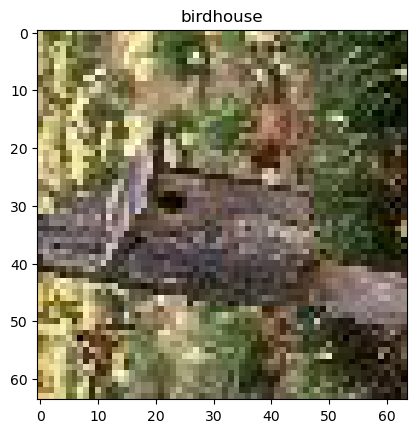

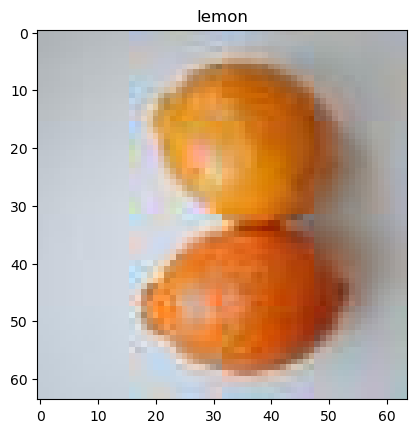

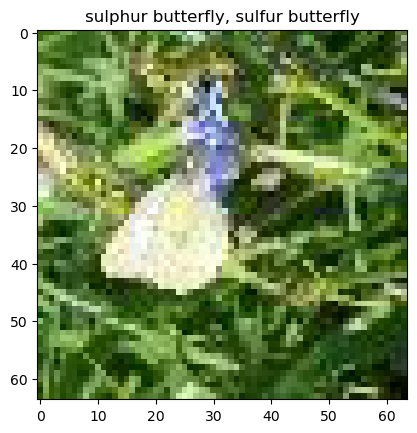

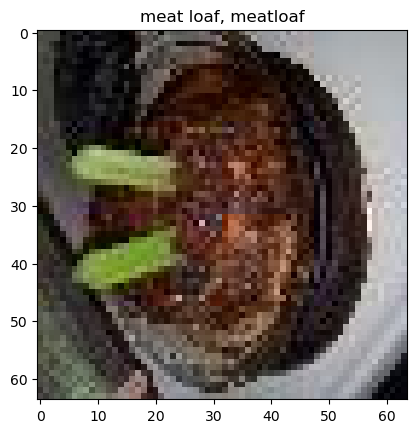

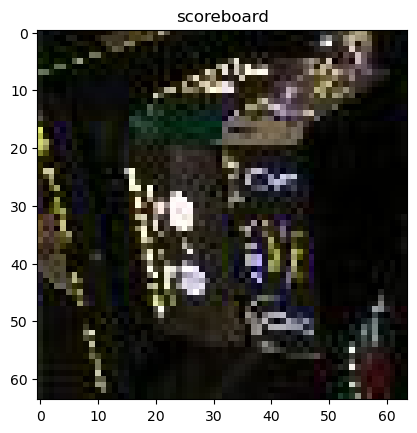

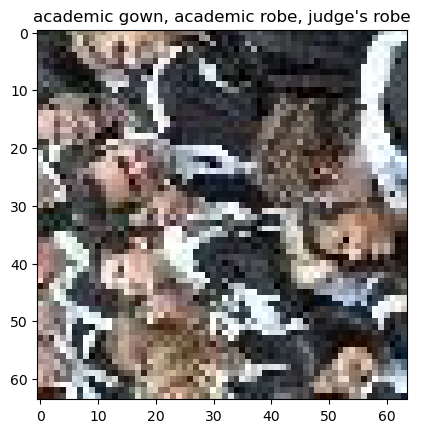

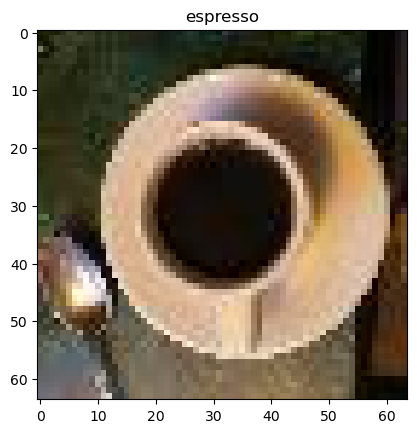

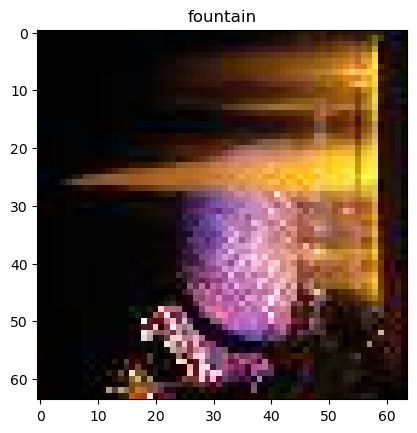

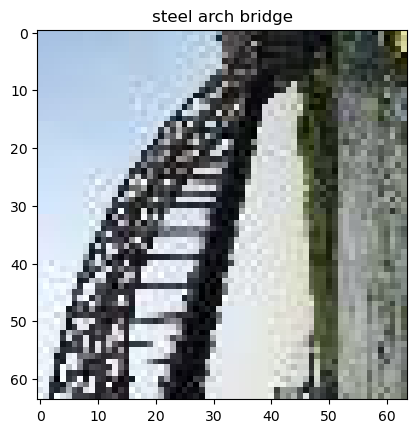

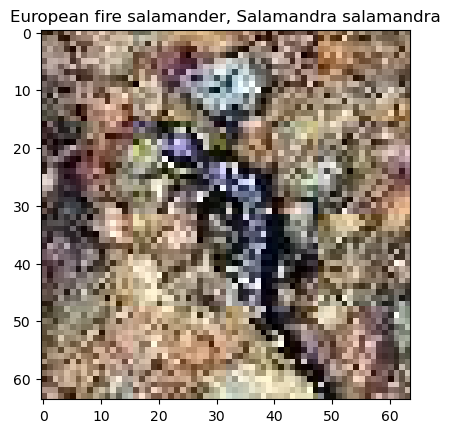

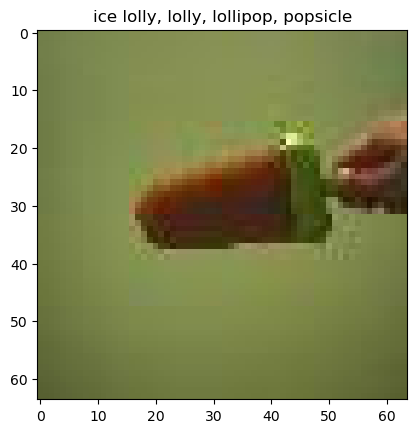

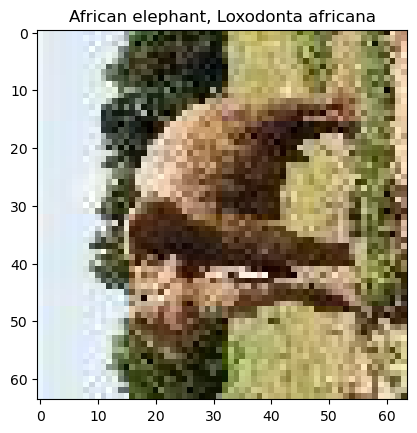

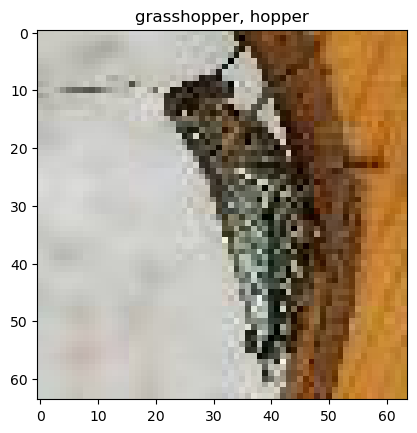

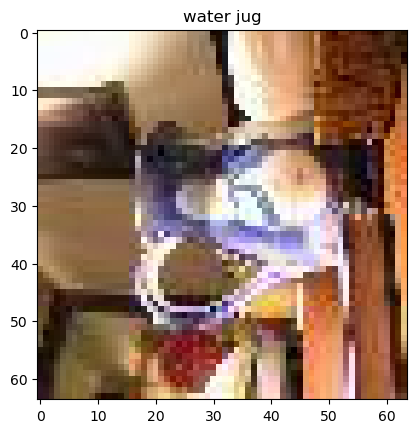

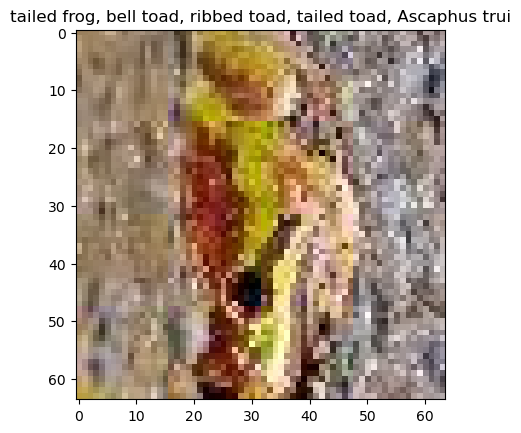

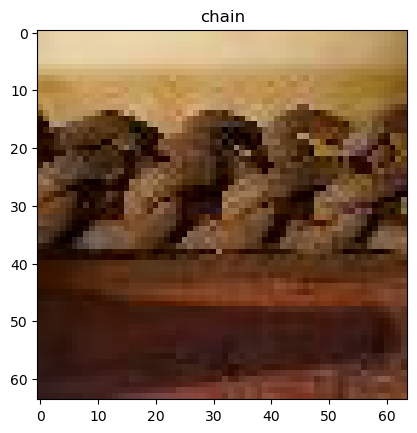

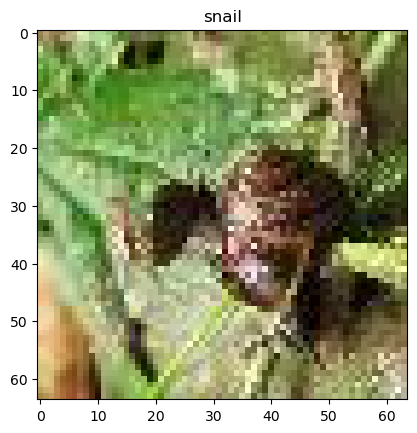

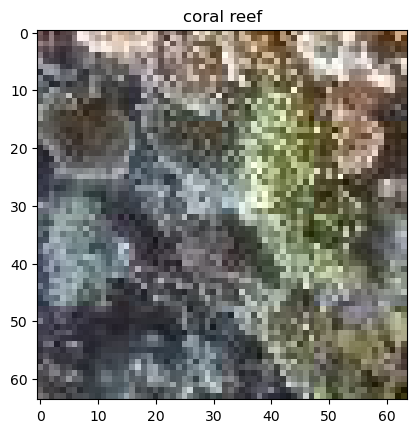

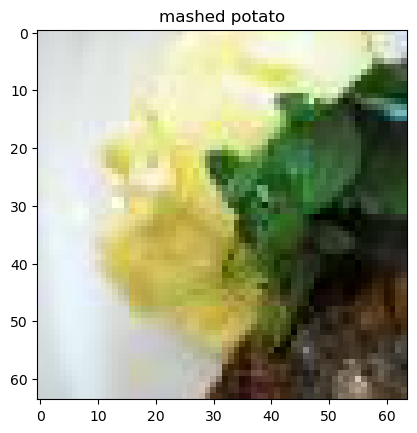

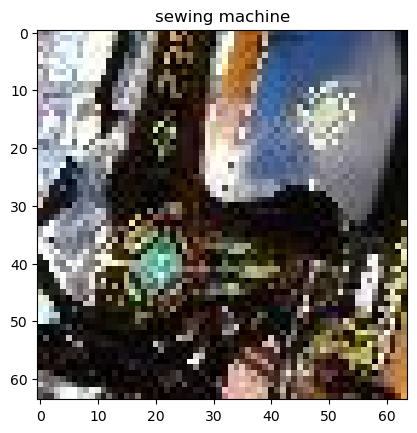

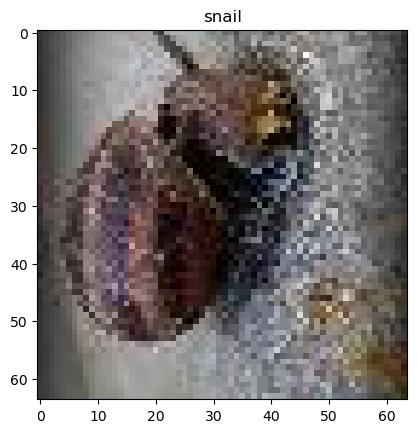

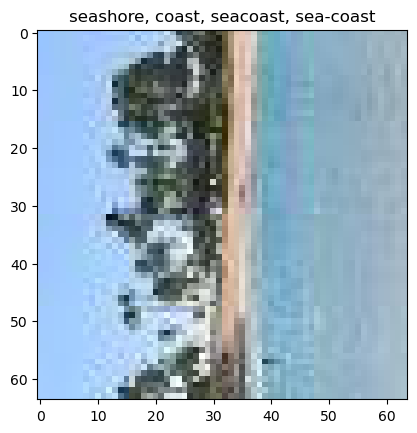

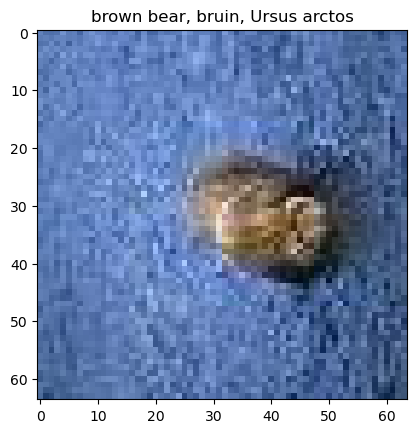

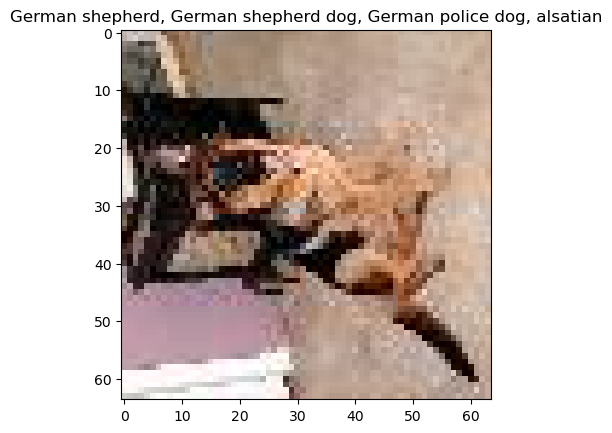

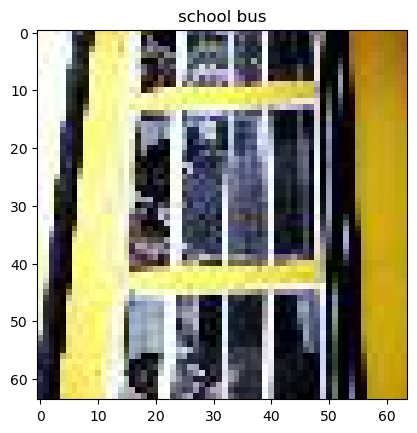

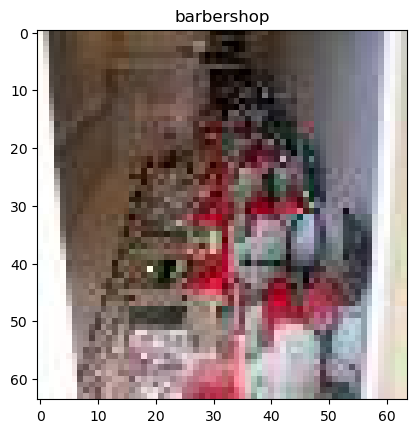

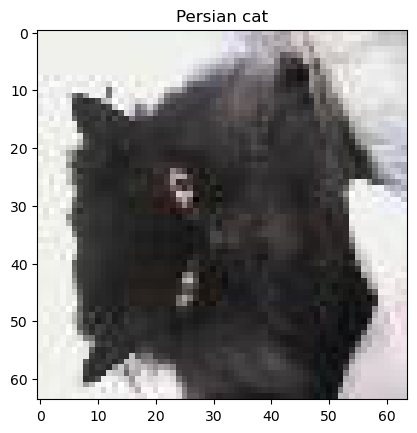

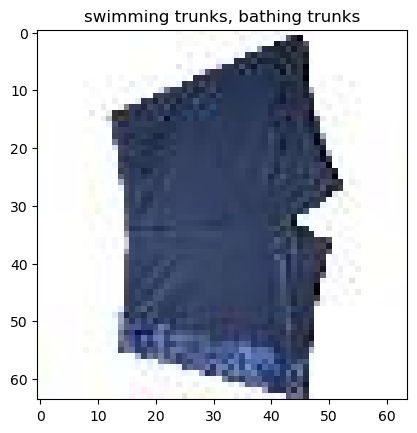

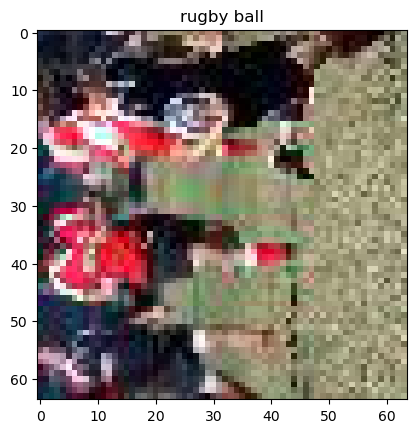

<Figure size 640x480 with 0 Axes>

In [14]:
label_map = pd.read_csv("tiny-imagenet-200/words.txt", delimiter='\t', header=None)
label_map = dict(zip(label_map[0], label_map[1]))
idx_to_class = {v:k for (k,v) in class_to_idx.items()}
for index, (data, labels) in enumerate(train_dataset):
    break
for image_index in range(len(data)):
    image = data[image_index].detach().numpy().T
    label = labels.detach().numpy()[image_index]
    plt.imshow(image)
    plt.title(f"{label_map[idx_to_class[label]]}")
    plt.figure()
plt.show()

## Linear Model in PyTorch

In [15]:
# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=20)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (640, 12288)
Training Labels Shape: (640,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [16]:
class LinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        self.activation = torch.nn.LogSigmoid()
    
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation(X)
        return X

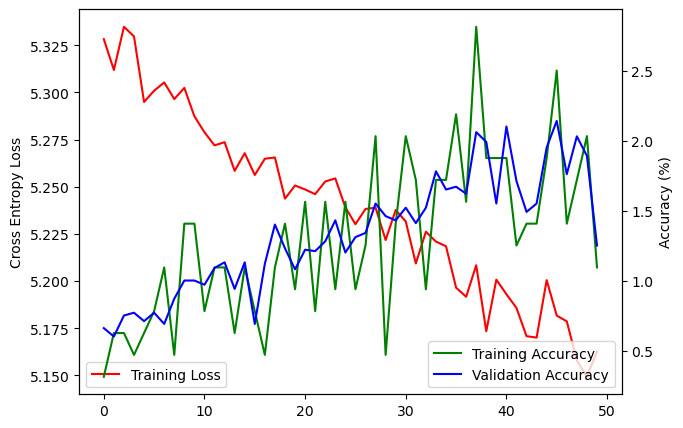

In [17]:
batch_limit = 20

# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 50
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Linear Model In PyTorch - 10x Training Data

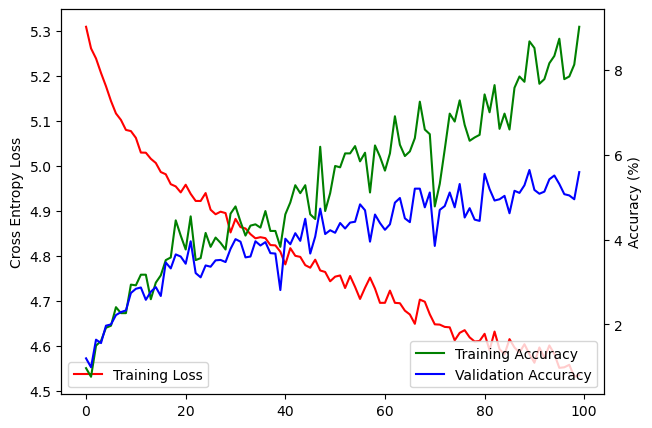

In [13]:
batch_limit = 200

# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Nonlinear Neural Network With One Hidden Layer

In [14]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (6400, 12288)
Training Labels Shape: (6400,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [15]:
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X

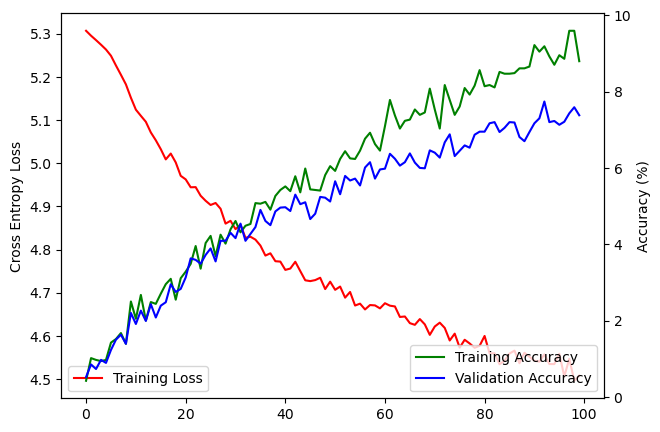

In [16]:
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 


## Convolutional Neural Network in PyTorch

In [17]:
class ConvNet(torch.nn.Module):
     
    def __init__(self, h, w, outputs):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = torch.nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


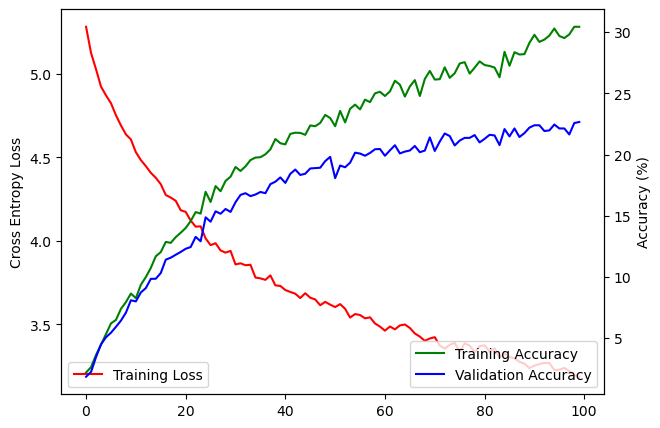

In [18]:
batch_limit = 200
num_features = train_data_np[0].shape  # (64, 64, 3)
num_classes = 200
max_iter = 100
model = ConvNet(64, 64, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, 3, 64, 64)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, 3, 64, 64)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 
